<a href="https://colab.research.google.com/github/jacobadodge/Spring2024_CVENG_8160/blob/main/Accuracy_GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# CHAGNE DIRECTORY

%cd '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)'

/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)


In [3]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# !gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
# !gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

In [5]:
# !unzip 'train.zip' -d '.'
# !unzip 'test.zip' -d '.'

In [6]:
# SPLIT DATA INTO TEST AND TRAIN

df = pd.read_pickle('tps_df.pkl')
test = .2
df_len = df.shape[0]
df_train, df_test = df.iloc[0:df_len - int(test*df_len)], df.iloc[df_len - int(test*df_len):]
df_train.to_csv('data/train2.csv', index = False)  # save training data as 'train.csv' in 'data' folder
df_test.to_csv('data/test2.csv', index = False)  # save testing data as 'test.csv' in 'data' folder
df_train.shape, df_test.shape

((1012750, 8), (253187, 8))

In [7]:
class TrafficForecast():
    def __init__(self,pkl_path, window, horizon):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []


        df = pd.read_csv(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")
            TI_series = df_seg_id['TrafficIndex_GP'].values
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]

                self.inputs.append(x)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window,1)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [8]:
# CREATE OBJECT FOR TRIANING AND TESTING

tobj_train = TrafficForecast('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/data/train2.csv',10,36)
tobj_test = TrafficForecast('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/data/test2.csv',10,36)

In [9]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# for idx, data in enumerate(dataloader_train):
#     print (data['inputs'].shape,data['outputs'].shape)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from models import MyLSTM, MyGRU

In [13]:
model = MyLSTM(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):


  # TRAINING MODEL
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


  # TESTING MODEL
  for i_test,sample_test in enumerate(dataloader_test):
      outputs = model(sample_test['inputs'].to(device))
      test_loss = criterion(outputs, sample_test['outputs'].to(device))
      test_losses.append(test_loss.item())


  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')


#CALCULATE ACCURACY OF THE MODEL
import math
mean_test_mse = sum(test_losses) / len(test_losses)
mean_test_rmse = math.sqrt(mean_test_mse)
print('The rmse for the model is', mean_test_rmse)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 33%|███▎      | 1/3 [01:03<02:07, 63.73s/it]

Epoch 1/3, Training Loss: 0.0636, Testing Loss: 0.0034


 67%|██████▋   | 2/3 [02:09<01:05, 65.01s/it]

Epoch 2/3, Training Loss: 0.0386, Testing Loss: 0.0031


100%|██████████| 3/3 [03:15<00:00, 65.05s/it]

Epoch 3/3, Training Loss: 0.0302, Testing Loss: 0.0027
The rmse for the model is 0.05206566027197086


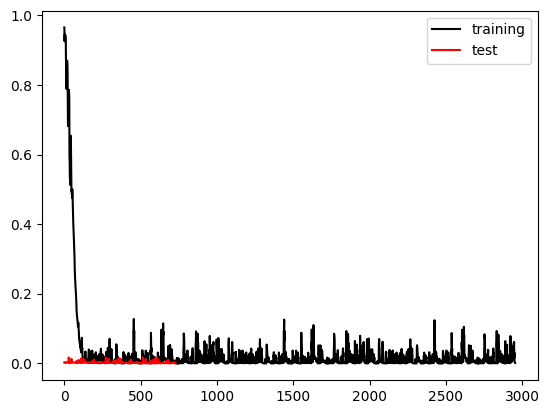

In [15]:
plt.plot(losses,'k',label='training')
plt.plot(test_losses, 'r', label = 'test')
plt.legend()

In [16]:
torch.save(model.state_dict(), "LSTMW10H36.pth")

#Above Program for Assignment: Calculate accuracy of GRU/LSTM model